# SPRINT 3

Quins llindars de saldo podrien indicar més risc de
morositat?

In [2]:
import pymysql
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

### CONEXIÓN

In [3]:
S3_df_BANK_marketing = pd.read_parquet('S3_df_BANK_marketing.parquet')
S3_df_BANK_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   26179 non-null  int64  
 1   age                  26179 non-null  float64
 2   job                  26179 non-null  object 
 3   marital              26179 non-null  object 
 4   education            26179 non-null  object 
 5   is_in_default        26179 non-null  float64
 6   balance              26179 non-null  int64  
 7   housing              26179 non-null  int64  
 8   loan                 26179 non-null  int64  
 9   contact              26179 non-null  object 
 10  day                  26179 non-null  int64  
 11  month                26179 non-null  object 
 12  duration             26179 non-null  int64  
 13  campaign             26179 non-null  int64  
 14  pdays                26179 non-null  int64  
 15  previous             26179 non-null 

In [4]:
print(S3_df_BANK_marketing.isnull().sum())
print(f"Los cantidad de duplicados es: {S3_df_BANK_marketing.duplicated().sum()}")


id                     0
age                    0
job                    0
marital                0
education              0
is_in_default          0
balance                0
housing                0
loan                   0
contact                0
day                    0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
poutcome               0
deposit                0
balance_normalizado    0
estado_balance         0
dtype: int64
Los cantidad de duplicados es: 0


Seleccionamos las columnas que útiles para el departamento de finanzas

In [5]:
df_f = S3_df_BANK_marketing[['id','age','job','marital','education','is_in_default','balance','housing','loan','balance_normalizado','estado_balance']]
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   26179 non-null  int64  
 1   age                  26179 non-null  float64
 2   job                  26179 non-null  object 
 3   marital              26179 non-null  object 
 4   education            26179 non-null  object 
 5   is_in_default        26179 non-null  float64
 6   balance              26179 non-null  int64  
 7   housing              26179 non-null  int64  
 8   loan                 26179 non-null  int64  
 9   balance_normalizado  26179 non-null  float64
 10  estado_balance       26179 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 2.2+ MB


In [6]:
df_f.head()

,id,age,job,marital,education,is_in_default,balance,housing,loan,balance_normalizado,estado_balance
0,1,59.0,admin.,married,secondary,0.0,2343,1,0,0.251390,Saldo Alto
1,2,59.0,admin.,married,secondary,0.0,2343,1,0,0.251390,Saldo Alto
2,3,56.0,admin.,married,secondary,0.0,45,0,0,-0.446981,Saldo Bajo
3,4,41.0,technician,married,secondary,0.0,1270,1,0,-0.074698,Saldo Medio Alto
4,5,55.0,services,married,secondary,0.0,2476,1,0,0.291810,Saldo Alto


In [7]:
df_f.describe()

,id,age,is_in_default,balance,housing,loan,balance_normalizado
count,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,2.617900e+04
mean,13170.265098,41.233546,0.015585,1515.796363,0.471523,0.130715,-2.849879e-17
std,7643.457481,11.887219,0.123866,3290.577468,0.499198,0.337095,1.000019e+00
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000,-2.541486e+00
25%,6545.500000,32.000000,0.000000,121.000000,0.000000,0.000000,-4.238840e-01
50%,13090.000000,39.000000,0.000000,544.000000,0.000000,0.000000,-2.953326e-01
75%,19844.500000,49.000000,0.000000,1689.000000,1.000000,0.000000,5.263725e-02
max,26389.000000,95.000000,1.000000,81204.000000,1.000000,1.000000,2.421755e+01


Vemos la cantidad total de cada opción a analizar

In [8]:
df_f['is_in_default'] = df_f['is_in_default'].astype(int)

df_f['is_in_default'].value_counts()


C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\2159677967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['is_in_default'] = df_f['is_in_default'].astype(int)


is_in_default
0    25771
1      408
Name: count, dtype: int64

Ordenamos la categoria estado_balance

In [9]:
estado_balance_order = ['Saldo Muy Alto', 'Saldo Alto', 'Saldo Medio Alto', 'Saldo Medio', 'Saldo Bajo', 'Saldo Muy Bajo']
df_f['estado_balance'] = pd.Categorical(df_f['estado_balance'], categories=estado_balance_order, ordered=True)

C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\4283965127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['estado_balance'] = pd.Categorical(df_f['estado_balance'], categories=estado_balance_order, ordered=True)


Observamos la cantidad de morosidad por categroia de balance

In [10]:
conteo = df_f.groupby('estado_balance')['is_in_default'].value_counts()
conteo

C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\2467586623.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df_f.groupby('estado_balance')['is_in_default'].value_counts()


estado_balance    is_in_default
Saldo Muy Alto    0                2459
                  1                   3
Saldo Alto        0                4081
                  1                   4
Saldo Medio Alto  0                6522
                  1                  27
Saldo Medio       0                6503
                  1                  44
Saldo Bajo        0                6199
                  1                 329
Saldo Muy Bajo    0                   7
                  1                   1
Name: count, dtype: int64

### EDA

#### ANALISIS DESCRIPTIVO

In [11]:
df_f.groupby('is_in_default')['balance'].describe()


,count,mean,std,min,25%,50%,75%,max
is_in_default,,,,,,,,
0,25771.0,1540.344845,3309.264782,-3058.0,131.0,559.0,1716.00,81204.0
1,408.0,-34.789216,772.679081,-6847.0,-338.0,0.0,68.25,5249.0


Los datos muestran que hay muchos más clientes sin morosidad (25,771) que morosos (408). Los clientes sin morosidad tienen un saldo medio de 1,540.34, mientras que los morosos tienen un saldo medio de -34.79. La variabilidad del saldo es mayor entre los clientes sin morosidad. Los saldos de los clientes sin morosidad varían ampliamente de -3,058 a 81,204, mientras que los morosos tienen saldos que van de -6,847 a 5,249, con muchos valores negativos. Además, los percentiles indican que la mayoría de los clientes morosos tienen saldos bajos o negativos. 

En este primer análisis se puede ver que los clientes morosos tienden a tener saldos significativamente más bajos o negativos en comparación con los clientes sin morosidad.

- Tasa promedia de is_in_default segun estado_balance

In [12]:
estado_balance_mean = df_f.groupby('estado_balance')['is_in_default'].mean()
estado_balance_mean_percent = (estado_balance_mean * 100).round(2)
estado_balance_mean_percent

C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\2637152361.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estado_balance_mean = df_f.groupby('estado_balance')['is_in_default'].mean()


estado_balance
Saldo Muy Alto       0.12
Saldo Alto           0.10
Saldo Medio Alto     0.41
Saldo Medio          0.67
Saldo Bajo           5.04
Saldo Muy Bajo      12.50
Name: is_in_default, dtype: float64

Los datos sugieren que los clientes con saldos más bajos (Saldo Muy Bajo y Saldo Bajo) tienen un riesgo significativamente mayor de estar en morosidad. A medida que el saldo disminuye, la proporción de clientes en impago aumenta notablemente. Por el contrario, los clientes con saldos altos y muy altos tienen un menor riesgo de morosidad. 

#### TESTS ESTADÍSTICOS

##### Test T y Prueba de U para is_in_default con balance

In [13]:
from scipy.stats import ttest_ind, mannwhitneyu

morosos = df_f[df_f['is_in_default'] == 1]['balance']
no_morosos = df_f[df_f['is_in_default'] == 0]['balance']

t_stat, t_p_value = ttest_ind(morosos, no_morosos, equal_var=False)
u_stat, u_p_value = mannwhitneyu(morosos, no_morosos)
print(f"T-Test p-value: {t_p_value}")
print(f"Mann-Whitney U p-value: {u_p_value}")


T-Test p-value: 1.0416921596077364e-160
Mann-Whitney U p-value: 9.855332429429326e-128


Estos resultados apoyan la hipótesis de que el saldo es un factor importante que puede estar relacionado con el riesgo de morosidad. En otras palabras, los saldos más bajos están asociados con una mayor probabilidad de morosidad, y esta relación es estadísticamente significativa.

Estos hallazgos refuerzan la importancia de considerar el saldo como un indicador clave del riesgo de impago al evaluar la solvencia de los clientes.

In [14]:
from scipy.stats import chi2_contingency

tabla_con = pd.crosstab(df_f['estado_balance'], df_f['is_in_default'])
chi2, p, dof, expected = chi2_contingency(tabla_con)
print(f"Chi2 Test p-value: {p}")

Chi2 Test p-value: 2.3696095851110265e-149


El resultado del test Chi-cuadrado sugiere que existe una relación estadísticamente significativa entre las categorías de saldo (estado_balance) y el estado de morosidad (is_in_default).

#### PRIMERAS VISUALIZACIONES

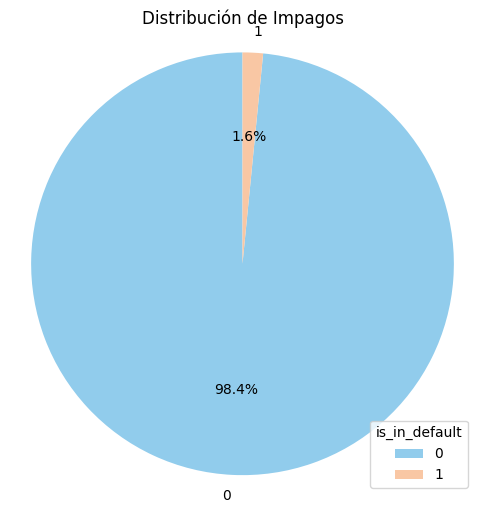

In [15]:
default_counts = df_f['is_in_default'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=default_counts.index, autopct='%1.1f%%', startangle=90, colors=['#91ccec', '#f9c7a4'])
plt.title('Distribución de Impagos')
plt.legend(default_counts.index, title="is_in_default", loc="lower right")
plt.axis('equal')  
plt.show()

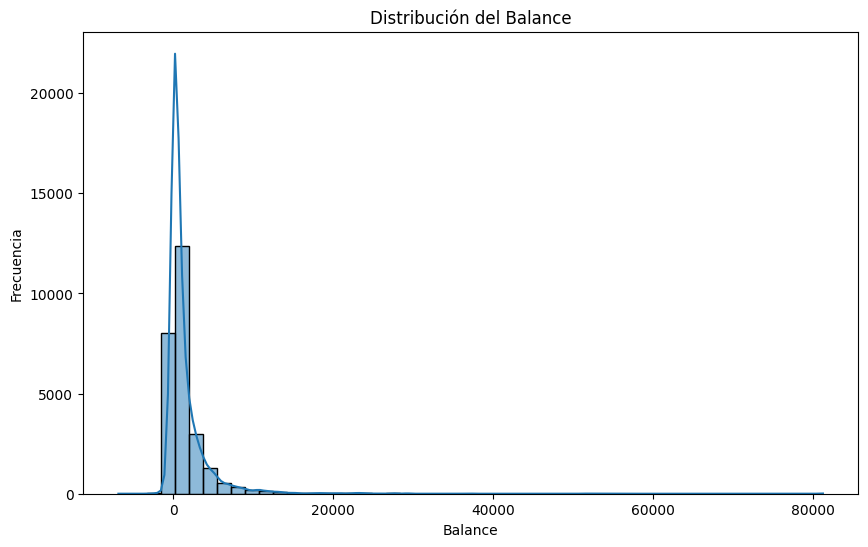

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_f['balance'], bins=50, kde=True)
plt.title('Distribución del Balance')
plt.xlabel('Balance')
plt.ylabel('Frecuencia')
plt.show()

##### Histograma de la Distribución de Saldos por Estado de Morosidad

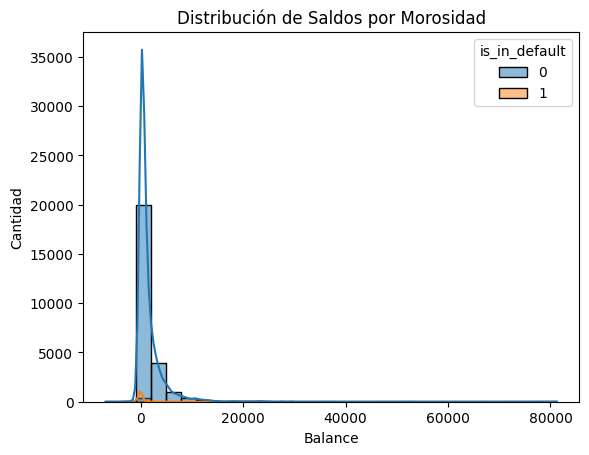

In [17]:
sns.histplot(data=df_f, x='balance', hue='is_in_default', kde=True, bins=30)
plt.title('Distribución de Saldos por Morosidad')
plt.xlabel('Balance')
plt.ylabel('Cantidad')
plt.show()



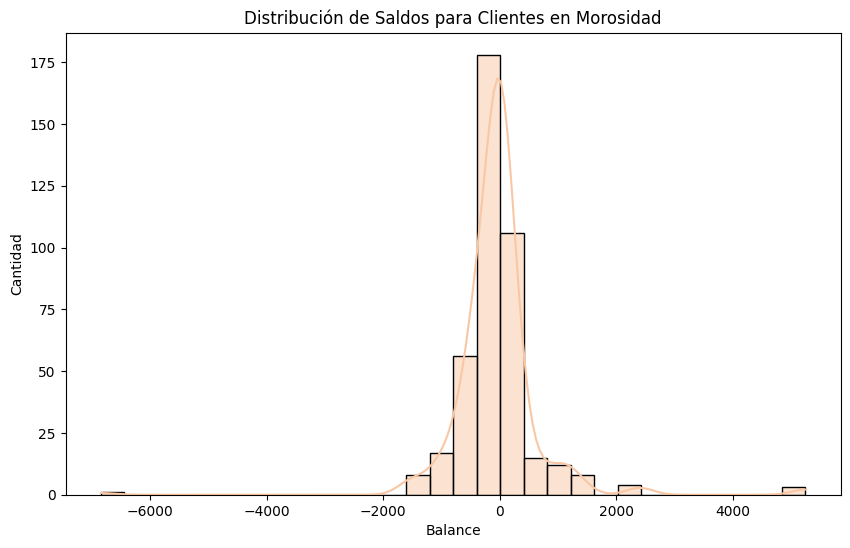

In [18]:
# Filtrar los datos para incluir solo clientes en morosidad
df_morosos = df_f[df_f['is_in_default'] == 1]


plt.figure(figsize=(10, 6))
sns.histplot(data=df_morosos, x='balance', kde=True, bins=30, color='#f9c7a4')
plt.title('Distribución de Saldos para Clientes en Morosidad')
plt.xlabel('Balance')
plt.ylabel('Cantidad')
plt.show()


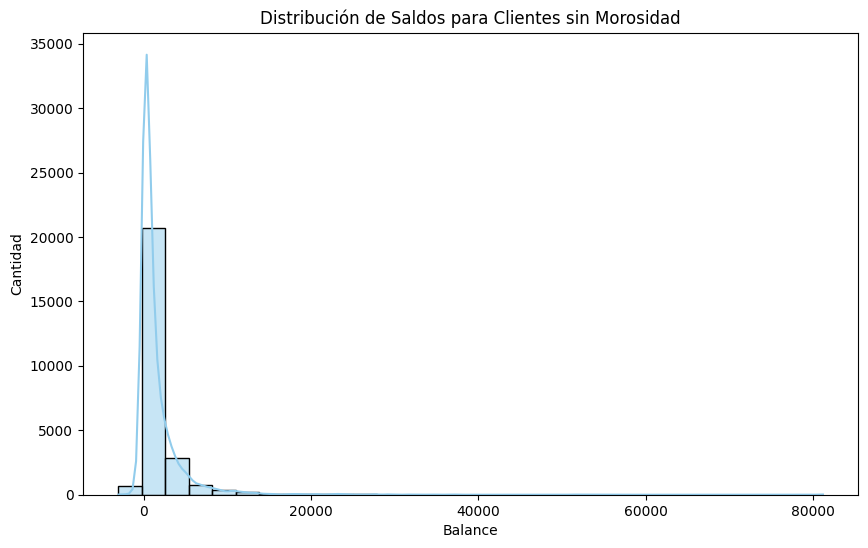

In [19]:
df_no_morosos = df_f[df_f['is_in_default'] == 0]


plt.figure(figsize=(10, 6))
sns.histplot(data=df_no_morosos, x='balance', kde=True, bins=30, color='#91ccec')
plt.title('Distribución de Saldos para Clientes sin Morosidad')
plt.xlabel('Balance')
plt.ylabel('Cantidad')
plt.show()

##### Boxplot del Balance por Estado de Morosidad

C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\2509617578.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='is_in_default', x='balance', data=df_f, palette='coolwarm', orient='h')


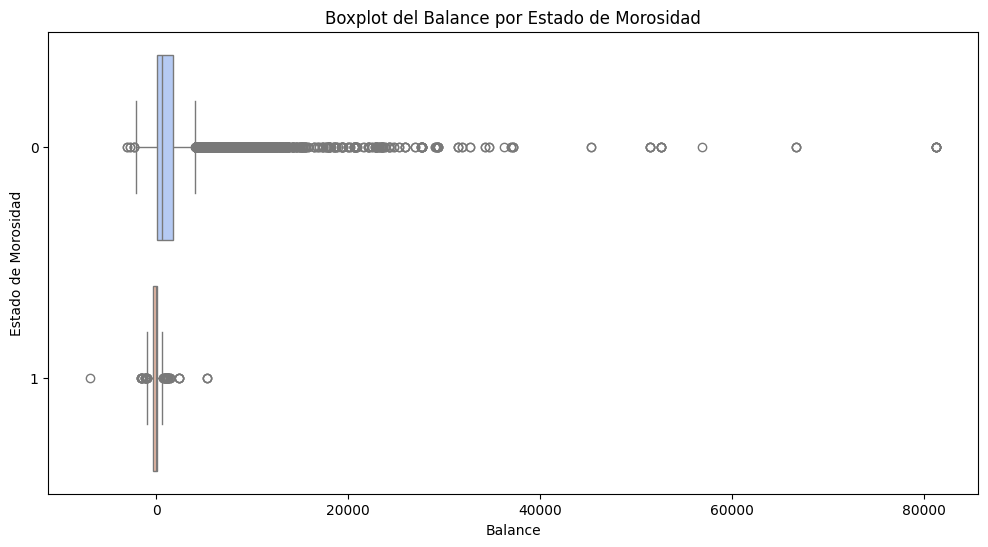

In [20]:


plt.figure(figsize=(12, 6))
sns.boxplot(y='is_in_default', x='balance', data=df_f, palette='coolwarm', orient='h')
plt.title('Boxplot del Balance por Estado de Morosidad')
plt.ylabel('Estado de Morosidad')
plt.xlabel('Balance')
plt.show()



##### Balances por Categoría de Saldo según Morosidad

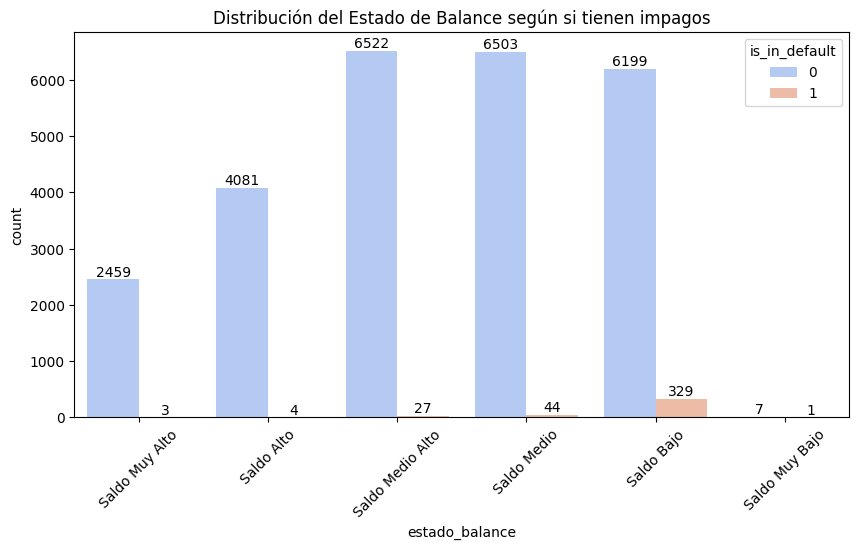

In [21]:
plt.figure(figsize=(10, 5))
num_marital = sns.countplot(data=df_f, x='estado_balance', hue = 'is_in_default',palette='coolwarm')
for bar in num_marital.containers: # número en las barras
    num_marital.bar_label(bar)
plt.title('Distribución del Estado de Balance según si tienen impagos')
plt.xticks(rotation=45)
plt.show()


# ANALISIS

##### Gráfico de Cuartiles de Saldos y Tasa de Morosidad

In [37]:
cuartiles, bin_edges = pd.qcut(df_f['balance'], 4, retbins=True, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Mostrar los puntos de corte
print("Puntos de corte de los cuartiles:")
for i in range(len(bin_edges) - 1):
    print(f"Cuartil {i+1}: de {bin_edges[i]:.2f} a {bin_edges[i+1]:.2f}")

Puntos de corte de los cuartiles:
Cuartil 1: de -6847.00 a 121.00
Cuartil 2: de 121.00 a 544.00
Cuartil 3: de 544.00 a 1689.00
Cuartil 4: de 1689.00 a 81204.00


- Creamos la categoria

In [38]:
df_f['balance_cuartiles'] = pd.qcut(df_f['balance'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
riesgo_cuartiles = df_f.groupby('balance_cuartiles')['is_in_default'].mean() * 100
riesgo_cuartiles.round(2)

C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\58448487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['balance_cuartiles'] = pd.qcut(df_f['balance'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\58448487.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  riesgo_cuartiles = df_f.groupby('balance_cuartiles')['is_in_default'].mean() * 100


balance_cuartiles
Q1    5.04
Q2    0.67
Q3    0.41
Q4    0.11
Name: is_in_default, dtype: float64

- Tabla para mostrar los resultados totales

In [39]:
crosstab_cuartiles = pd.crosstab(df_f['balance_cuartiles'], df_f['is_in_default'])
#Calculo del porcentaje
crosstab_cuartiles['%_0'] = (crosstab_cuartiles[0] / (crosstab_cuartiles[0] + crosstab_cuartiles[1]) * 100).round(2)
crosstab_cuartiles['%_1'] = (crosstab_cuartiles[1] / (crosstab_cuartiles[0] + crosstab_cuartiles[1]) * 100).round(2)
print(crosstab_cuartiles)

is_in_default         0    1    %_0   %_1
balance_cuartiles                        
Q1                 6220  330  94.96  5.04
Q2                 6503   44  99.33  0.67
Q3                 6514   27  99.59  0.41
Q4                 6534    7  99.89  0.11


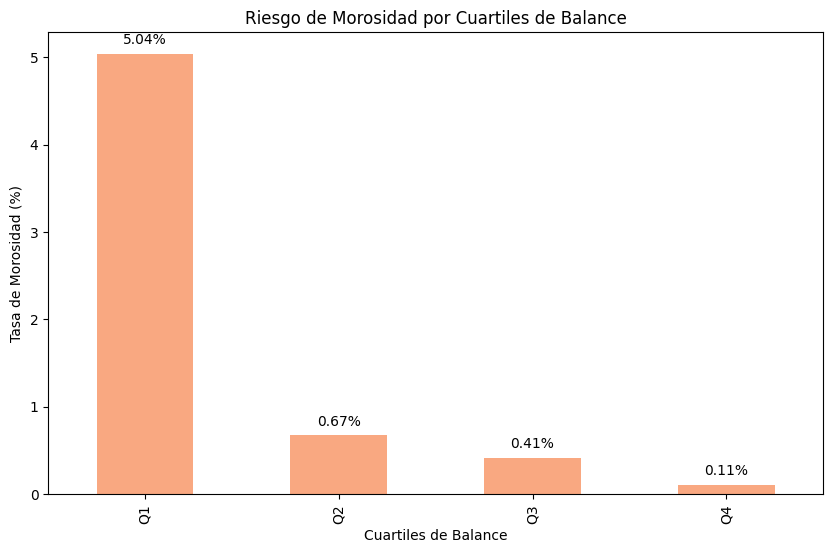

In [40]:
plt.figure(figsize=(10, 6))
ax = riesgo_cuartiles.plot(kind='bar', color='#f9a881')
plt.xlabel('Cuartiles de Balance')
plt.ylabel('Tasa de Morosidad (%)')
plt.title('Riesgo de Morosidad por Cuartiles de Balance')

# Añadir porcentajes encima de las columnas
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

##### Riesgo de Morosidad por Categoría de Saldo

C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\744227427.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  riesgo_categoria_balance = df_f.groupby('estado_balance')['is_in_default'].mean().reset_index()
C:\Users\Adam\AppData\Local\Temp\ipykernel_18100\744227427.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=riesgo_categoria_balance, x='estado_balance', y='is_in_default', palette='coolwarm')


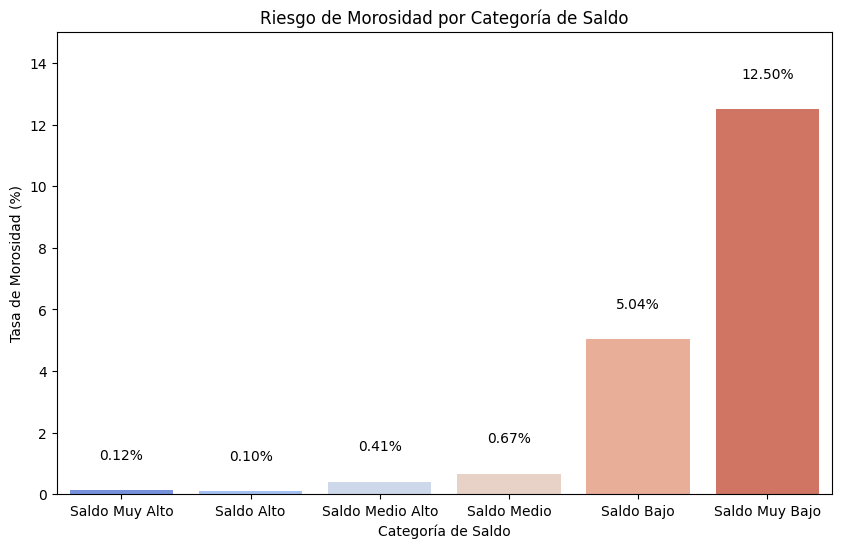

In [22]:
riesgo_categoria_balance = df_f.groupby('estado_balance')['is_in_default'].mean().reset_index()

# Convertir la tasa de morosidad a porcentaje
riesgo_categoria_balance['is_in_default'] = riesgo_categoria_balance['is_in_default'] * 100
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=riesgo_categoria_balance, x='estado_balance', y='is_in_default', palette='coolwarm')

# Añadir los porcentajes sobre las barras
for index, row in riesgo_categoria_balance.iterrows():
    barplot.text(index, row['is_in_default'] + 1, f"{row['is_in_default']:.2f}%", color='black', ha="center")

plt.title('Riesgo de Morosidad por Categoría de Saldo')
plt.xlabel('Categoría de Saldo')
plt.ylabel('Tasa de Morosidad (%)')
plt.ylim(0, 15) 
plt.show()


- Tabla para mostrar los resultados totales

In [23]:
crosstab_estado_balance = pd.crosstab(df_f['estado_balance'], df_f['is_in_default'])
#Calculo del porcentaje
crosstab_estado_balance['%_0'] = (crosstab_estado_balance[0] / (crosstab_estado_balance[0] + crosstab_estado_balance[1]) * 100).round(2)
crosstab_estado_balance['%_1'] = (crosstab_estado_balance[1] / (crosstab_estado_balance[0] + crosstab_estado_balance[1]) * 100).round(2)
print(crosstab_estado_balance)


is_in_default        0    1    %_0    %_1
estado_balance                           
Saldo Muy Alto    2459    3  99.88   0.12
Saldo Alto        4081    4  99.90   0.10
Saldo Medio Alto  6522   27  99.59   0.41
Saldo Medio       6503   44  99.33   0.67
Saldo Bajo        6199  329  94.96   5.04
Saldo Muy Bajo       7    1  87.50  12.50


# CONCLUSIONES

- Los saldos muy bajos (87.50% de no morosos) y bajos (94.96% de no morosos) tienen un riesgo significativamente mayor comparado con saldos altos y muy altos (99.88% y 99.90% de no morosos, respectivamente).

- Para mitigar el riesgo de morosidad en clientes con saldos bajos y muy bajos,se aconseja implementar programas de educación financiera, alertas tempranas, y asistencia financiera, a la vez que, ofrecer planes de pago flexibles y personalizar el asesoramiento financiero para apoyar a estos clientes.